In [1]:
import numpy as np # linear cebir
import pandas as pd # veri işleme, CSV dosyası G / Ç (ör. pd.read_csv) olarak içe aktarma
import tensorflow as tf
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

In [3]:
#loading dataframes
train_df = pd.read_csv('../input/rsna-bone-age/boneage-training-dataset.csv')
test_df = pd.read_csv('../input/rsna-bone-age/boneage-test-dataset.csv')

#appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 

train_df.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


array([[<AxesSubplot:title={'center':'boneage'}>]], dtype=object)

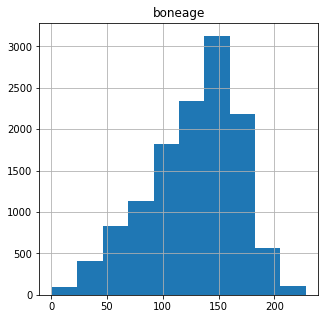

In [4]:
train_df[['boneage']].hist(figsize=(5,5))

male      6833
female    5778
Name: gender, dtype: int64


<AxesSubplot:xlabel='gender', ylabel='count'>

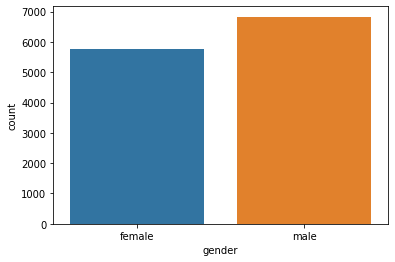

In [5]:
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
print(train_df['gender'].value_counts())
sns.countplot(x = train_df['gender'])

In [6]:
# veri kümesindeki en büyük çocuk
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

# veri kümesindeki en küçük çocuk
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

# ortalama yaş
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

# medyan kemik yaşı
print('median: ' +str(train_df['boneage'].median()))

# kemik yapısının standart sapması
std_bone_age = train_df['boneage'].std()

# modellerde , özellikler sıfır ortalamaya ve birlik standart sapmasına sahip olacak şekilde normalleştirildiğinde daha iyi performans gösterir
# eğitim için z puanını kullanma
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

print(train_df.head())

MAX age: 228 months
MIN age: 1 months
mean: 127.3207517246848
median: 132.0
         id  boneage   male  gender  bone_age_z
0  1377.png      180  False  female    1.279181
1  1378.png       12  False  female   -2.800269
2  1379.png       94  False  female   -0.809109
3  1380.png      120   True    male   -0.177766
4  1381.png       82  False  female   -1.100498


In [7]:
# her cinsiyet içinde yaş dağılımı
male = train_df[train_df['gender'] == 'male']
female = train_df[train_df['gender'] == 'female']

In [8]:
# train veri çerçevesini eğitim ve doğrulama veri çerçevelerine dönüştürme
df_train, df_valid = train_test_split(train_df, test_size = 0.25, random_state = 2018)

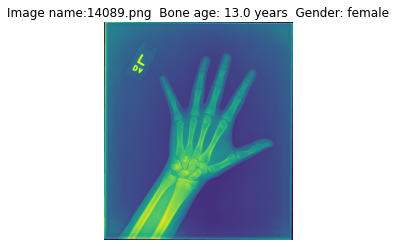

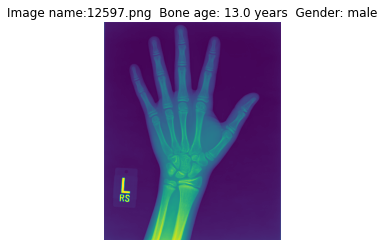

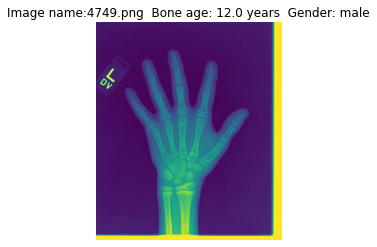

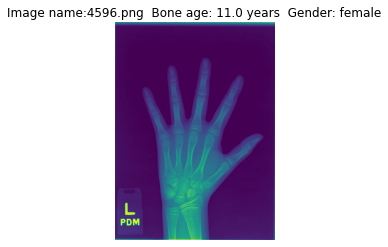

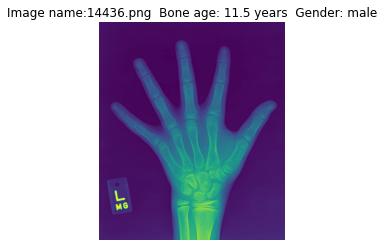

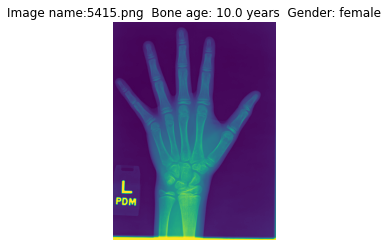

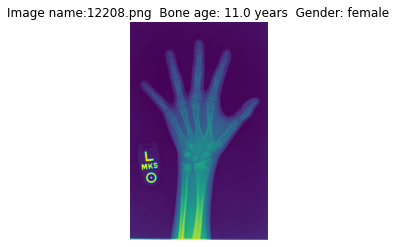

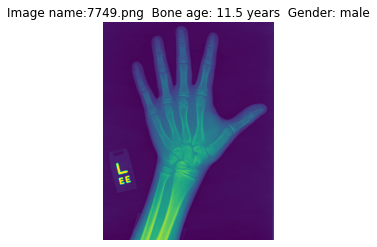

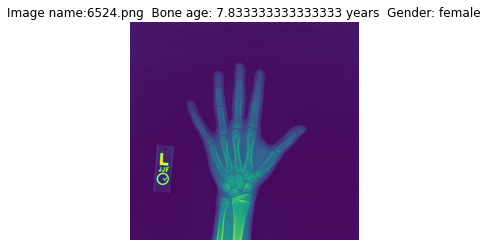

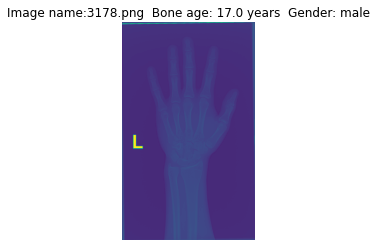

In [9]:
import matplotlib.image as mpimg
for filename, boneage, gender in train_df[['id','boneage','gender']].sample(10).values:
    img = mpimg.imread('../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/'+ filename)
    plt.imshow(img)
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender))
    plt.axis('off')
    plt.show()

In [10]:
img_size = 384

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = df_train, directory = '../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset',
    x_col= 'id', y_col= 'boneage', batch_size = 32, seed = 42,
    shuffle = True, class_mode= 'raw', flip_vertical = True,
    color_mode = 'rgb', target_size = (img_size, img_size))

validation_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid, directory = '../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset',
    x_col= 'id', y_col= 'boneage', batch_size = 256, seed = 42,
    shuffle = True, class_mode= 'raw', flip_vertical = True,
    color_mode = 'rgb', target_size = (img_size, img_size))

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    directory = '../input/rsna-bone-age/boneage-test-dataset',
    shuffle = False, 
    class_mode = None,
    color_mode = 'rgb',
    target_size = (img_size,img_size))

Found 9458 validated image filenames.
Found 3153 validated image filenames.
Found 200 images belonging to 1 classes.


In [11]:
test_X, test_Y = next(val_data_generator.flow_from_dataframe( 
                            dataframe = df_valid, directory = '../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset',
                            x_col = 'id', y_col = 'boneage', 
                            target_size = (img_size, img_size),
                            batch_size = 1024,
                            class_mode = 'raw'
                            ))

Found 3153 validated image filenames.


In [12]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Sequential
from keras.models import Model
input_shape = Input(test_X.shape[1:]) 
base_VGG16_model = VGG16(input_shape =  test_X.shape[1:], 
                                 include_top = False, weights = None)
bone_age_model = Sequential()
bone_age_model.add(base_VGG16_model)
bone_age_model.add(GlobalAveragePooling2D())
bone_age_model.add(Dropout(0.5))
bone_age_model.add(Dense(1, activation = 'linear' )) # linear is what 16bit did

base_VGG16_model.trainable = False
pt_depth = base_VGG16_model.get_output_shape_at(0)[-1]
pt_features = base_VGG16_model(input_shape)

from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = LocallyConnected2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(1024, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'linear')(dr_steps) # linear is what 16bit did
bone_age_model = Model(inputs = [input_shape], outputs = [out_layer])

from keras.metrics import mean_absolute_error
def mse(in_gt, in_pred):
    return mean_absolute_error(std_bone_age*in_gt, std_bone_age*in_pred)

bone_age_model.compile(optimizer = 'adam', loss = 'mean_squared_error',
                           metrics = [mse])

bone_age_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 12, 12, 512)  14714688    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 12, 12, 512)  2048        vgg16[1][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 12, 12, 64)   32832       batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_modelo1.h5".format('bone_age')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [14]:
history = bone_age_model.fit_generator(train_generator, 
                                  steps_per_epoch = 100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
100/100 [==============================] - 2459s 25s/step - loss: 12814.9326 - mse: 4120.5567 - val_loss: 1657.0131 - val_mse: 1352.3510

Epoch 00001: val_loss improved from inf to 1657.01306, saving model to bone_age_modelo1.h5
Epoch 2/5
100/100 [==============================] - 2458s 25s/step - loss: 1747.9649 - mse: 1401.8518 - val_loss: 1657.0441 - val_mse: 1344.8276

Epoch 00002: val_loss did not improve from 1657.01306
Epoch 3/5
100/100 [==============================] - 2480s 25s/step - loss: 1678.9240 - mse: 1375.7543 - val_loss: 1657.9333 - val_mse: 1356.7552

Epoch 00003: val_loss did not improve from 1657.01306
Epoch 4/5
100/100 [==============================] - 2496s 25s/step - loss: 1769.1388 - mse: 1417.6037 - val_loss: 1666.6606 - val_mse: 1370.0353

Epoch 00004: val_loss did not improve from 1657.01306
Epoch 5/5
100/100 [==============================] - 2482s 25s/step - loss: 1619.7045 - mse: 1362.0795 - val_loss: 1692.7429 - val_mse: 1329.2518

Epoch 00005

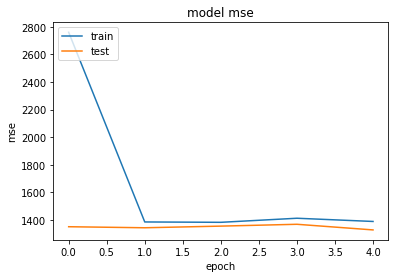

In [15]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
results = bone_age_model.evaluate(test_X, test_Y)
print("\nMSE: %.2f" % (results[1]))

32/32 [==============================] - 586s 18s/step - loss: 1692.7429 - mse: 1329.2518

MSE: 1329.25


In [17]:
# load the best version of the model
bone_age_model.save('modelo1.h5')

In [18]:
pred = bone_age_model.predict(test_X, batch_size = 32, verbose = True)

32/32 [==============================] - 599s 19s/step


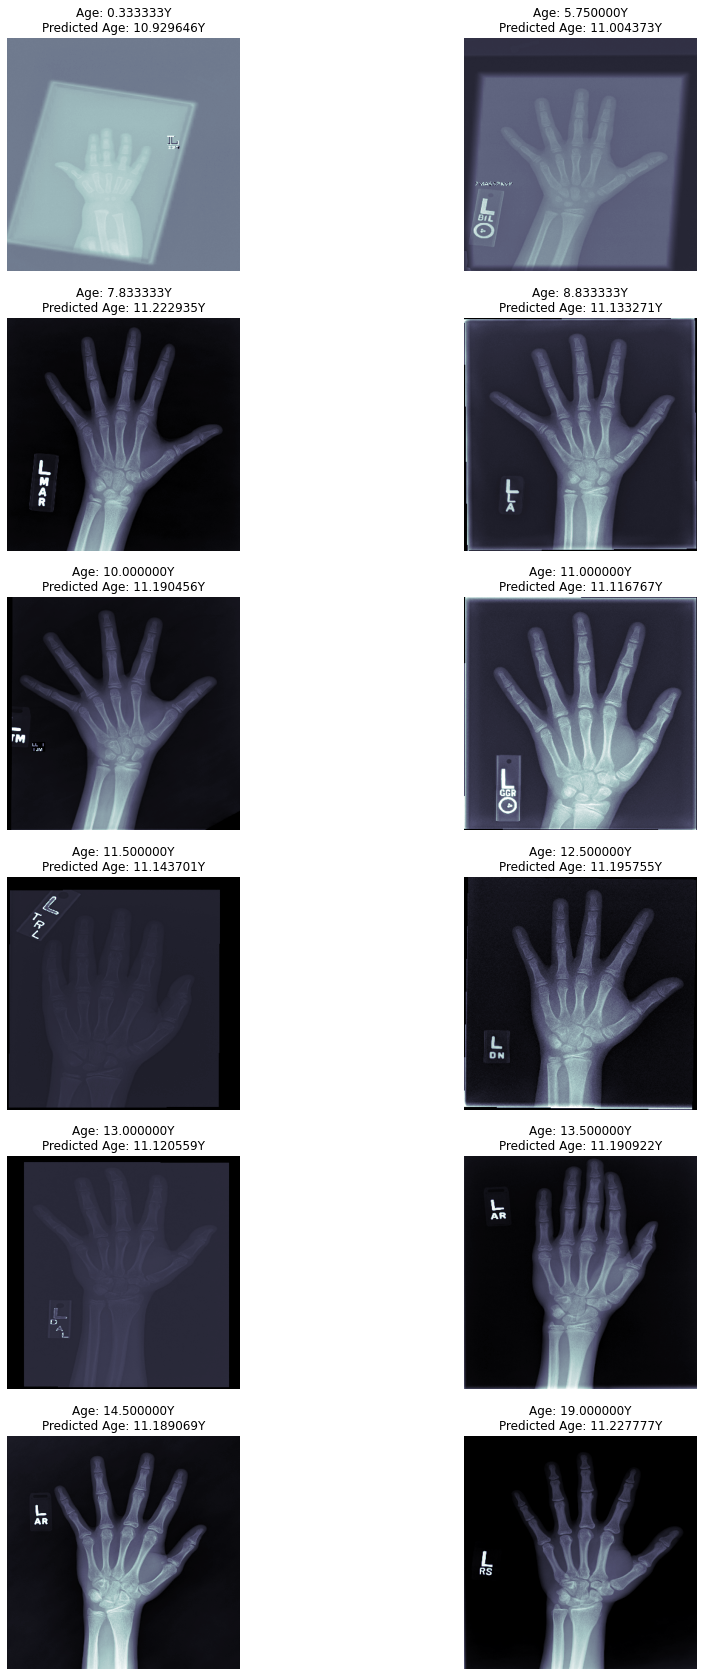

In [19]:
test_months = (test_Y)

ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 12).astype(int)] 
fig, axs = plt.subplots(6, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           pred[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)

Text(0, 0.5, 'Predicted Age (Months)')

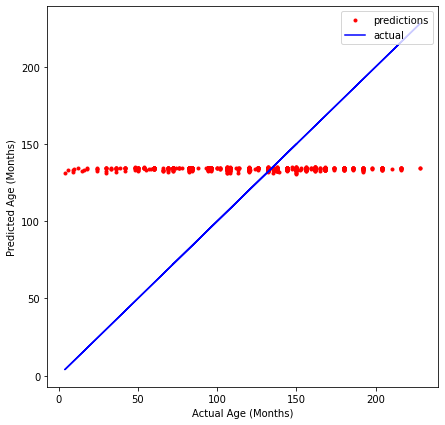

In [20]:
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_months, pred, 'r.', label = 'predictions')
ax.plot(test_months, test_months, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')